<a href="https://colab.research.google.com/github/vlozg/aicovid/blob/main/%5BTorch009_base_local%5D_AICOVID_115M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Aug 20 21:45:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:2D:00.0  On |                  N/A |
|  0%   43C    P8    18W / 170W |    448MiB / 12045MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Thí nghiệm trước mình đã thực hiện tinh chỉnh engineering khá nhiều, đặc biệt là việc tạo ra class dataset hoàn chỉnh cũng như tạo ra sampler phục vụ việc oversampling/undersampling. Bên cạnh đó mình còn giải quyết được vấn đề chunking gây bùng nổ data và cải thiện lại lightning module để có thể thực hiện multi-task learning.

Các vấn đề tồn đọng cho tới hiện tại:
- Tinh chỉnh lại code để hoạt động được với lightning 1.4.0

Trong notebook này, trọng tâm mình sẽ thử xoay quanh AST. Sở dĩ mình chuyển qua một phiên bản thí nghiệm mới vì mình nhận thấy rằng transformer có cách sử dụng với sequence khác với CNN nên tạo phiên bản mới để có thể dễ dàng quản lý, cũng như trong này mình hy vọng có thể học hỏi và hiểu rõ hơn về vision transformer.

exp000: Thử pretrain AST trên audioset. --> Chỉ chạy được batch size là 3. Rất chậm, memory tiêu tốn rất lớn.

exp001: Tinh chỉnh lại, remove bớt các thành phần đã được handle bởi lightning, loại bỏ MLP head vì cái này task dependent.

exp001-exp003_db: train model thất bại, không có dấu hiệu cải thiện của model khi loại bỏ đi 1 lớp linear giữa cls token và linear từng task. Đề xuất 2 hướng: (1) thêm 1 lớp giữa nhưng nhẹ hơn (exp000 dùng 527); (2) train single task. Bên cạnh đó mình đọc paper thì cũng bị khó hiểu khi tác giả lại mix cls với dist cls token trong quá trình train, trong khi suppose là dist cls token chỉ dùng khi có teacher?

***PHÁT HIỆN NGUYÊN NHÂN TRAIN KHÔNG ĐƯỢC: MODEL KHÔNG LOAD ĐƯỢC PRETRAINED WEIGHT***

exp003: fix bug thành công. --> 0.752

exp004: 
- Thử accumulate gradient batch 16 để được batchsize 64. Số lượng epoch dùng để train cần căn cứ theo tình hình fit của exp003 (tiêu chuẩn là gấp 16 lần, nhưng theo bên how to train resnet thì batchsize lớn cần ít epoch hội tụ hơn)? ✅
- Chỉnh tỉ lệ loss cho các task phụ vì theo quan sát gradient thì thấy chủ yếu khó khăn vì phải tối ưu gradient cho task phụ là chính, thậm chí còn dẫn tới performance trên task chính giảm sút. ✅
- Chỉnh lại model để cho phép inference trên length bất kỳ. 
- Thử chỉ classify với cls token 🔁

exp005:

exp006:

In [ ]:
#@title Lấy xác thực google để upload/download file
#@markdown Vui lòng bấm vào link khi được yêu cầu và lấy mã để nhập vào

# Xác thực google để upload/download qua google drive
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

class GDrive():
    def __init__(self, auth_type: str='colab'):
        self._gauth = GoogleAuth()
        self.auth_type = auth_type
        self._get_creds()
        self._drive = GoogleDrive(self._gauth)

    def _get_creds(self):
        if self.auth_type == 'colab':
            raise NotImplementedError()
        elif self.auth_type == 'local':
            self._gauth.LocalWebserverAuth()
        else:
            raise NotImplementedError()

    def Refresh_Auth(self):
        self._get_creds()

    def SearchInFolder(self, parent_id, file_name):
        self.Refresh_Auth()
        return self._drive.ListFile({'q': f"'{parent_id}' in parents and title = '{file_name}'"}).GetList()

    def CreateFile(self, file_name=None, parent_id=None):
        self.Refresh_Auth()
        file = self._drive.CreateFile({'title': file_name, 
                                       'parents': [{'id': parent_id}]})
        return file

    def Upload(self, file_path, parent_id, file_name=None):
        if file_name == None:
          file_name = file_path.split('/')[-1]
        # Kiểm tra file tồn tại
        file_list = self.SearchInFolder(parent_id, file_name)
        if len(file_list) > 1:
          for file in file_list:
            print('title: %s, id: %s' % (file['title'], file['id']))
          raise NameError('More than 1 file with same name exist, please resolve this')
        
        elif len(file_list) == 0:
          # File chưa có thì tạo mới
          file = self.CreateFile(file_name, parent_id)
        else:
          # Tồn tại duy nhất 1 file
          file = file_list[0]
        
        file.SetContentFile(file_path)
        file.Upload()

    def Download(self, file_name, parent_id):
        # Kiểm tra file tồn tại
        file_list = self.SearchInFolder(parent_id, file_name)
        if len(file_list) > 1:
            for file in file_list:
                print('title: %s, id: %s' % (file['title'], file['id']))
            raise NameError('More than 1 file with same name exist, please resolve this')
        elif len(file_list) == 0:
            raise NameError(f'File named {file_name} not exist')
        else:
            # Tồn tại duy nhất 1 file
            file = file_list[0]
        
        file.GetContentFile(file_name)

drive = GDrive('local')

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=324036170913-094orce5eji9sr78pstqsi3e6opo5jnp.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code

Opening in existing browser session.
Authentication successful.


In [ ]:
import os
from getpass import getpass

if not os.path.exists("tmp.tmp"):
    #@title Nhập Neptune API token
    api_token = getpass('Enter your private Neptune API token: ')
    with open('tmp.tmp', 'w') as tmp:
        tmp.write(api_token)
else:
    with open('tmp.tmp', 'r') as tmp:
        api_token = tmp.read()

# Detect COVID-19 patients via forced-cough cell phone recording

- **Bài toán**: Nhận diện người nhiễm COVID-19 qua tiếng ho ép buộc
    - **Input**: Đoạn ghi âm tiếng ho, tuổi và giới tính
    - **Output**: Phân loại người nhiễm bệnh hay không

## Tìm hiểu bài toán 
Qua paper (https://dspace.mit.edu/bitstream/handle/1721.1/128954/09208795.pdf?sequence=1&isAllowed=y)

## Đọc papers
[1] Kranthi Kumar Lella and Alphonse Pja (2021), *Automatic diagnosis of COVID-19 disease using deep convolutional neural network with multi-feature channel from respiratory sound data: Cough, voice, and breath*, access via: https://www.sciencedirect.com/science/article/pii/S1110016821003859

- Nguồn tham khảo tốt cho các paper có liên quan làm cùng chủ đề.
- Chỉ ra các paper trước đó không thành công lắm.
> From all these background work senses, there is **no accurate model** for diagnosing COVID-19 disease symptom
- Chỉ ra rằng hầu hết các dataset bị redundancy (1 speaker tạo nhiều mẫu).
- Dùng 4 loại augment: time stretch, shift pitch, dynamic range (nôm na là cân bằng volume), background noise inject.
- Dùng 3 channel: DAE (remove background noise), GFCC (short respiratory feature) và IMFCC (rich respiratory feature) -> Model có thực sự dùng hết cả 3 channel?
- Phần nói về implement hơi messed up (text mô tả kiến trúc 1 đường hình minh họa một nẻo?).

# Các biến thiết lập cho thử nghiệm

In [ ]:
# Nếu muốn train mô hình thì set thành True
experiment_id = '009' #@param {type:"string"}
val_split = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}

In [ ]:
# ID của folder lưu model trên drive
model_zoo = 'secret'
# ID của folder chứa submission
submission_folder = 'secret'
# Tên của file nén để nộp
zip_name = f'Torch_ver{experiment_id}'
# ID của folder chứa data đã preprocess
datadump_folder = 'secret'

# Setup
Import thư viện, tải data, đọc data, tạo helper function,...

## Import thư viện

In [ ]:
# Quản lý file, folder
import os

# Hiện audio nghe thử
import IPython.display as ipd
from IPython.display import Audio, display
from tqdm import tqdm

import random
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, WeightedRandomSampler, Sampler

# Xử lý audio
import torchaudio

import pytorch_lightning as pl

from torchinfo import summary

pl.utilities.seed.seed_everything(seed=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Global seed set to 1


device(type='cuda')

## Dataset class

In [ ]:
#@markdown ## Các hàm vỏ bọc cho đọc file
#@markdown `read_audio(path)`: vỏ bọc cho `torchaudio.load(path)`.<br>
#@markdown `read_resample_audio(path)`: chỉ trả về wave vì sample rate đã được cố định.

'''
  Read audio from given path and return (wave, sample_rate)
'''
def read_audio(full_audio_path):
  return torchaudio.load(full_audio_path)

'''
  Read audio from given path, then resample if sample rate is not matched 
  and return wave.

  Tips: 
    you should provide resampler from torchaudio.transform
    when batch resampling with same params since this can
    give a huge speed up.
'''
def read_resample_audio(
    full_audio_path, resample,
    resampler=None
):
  wave, sr = torchaudio.load(full_audio_path)
  if resampler is not None:
      wave = resampler(wave)
  elif sr != resample:
      wave = torchaudio.functional.resample(wave, sr, resample)
  return wave

In [ ]:
class AudioChunking(torch.nn.Module):
    def __init__(self,
                 chunk_size: int=400,
                 chunk_step: int=200,
                 idx_instead: bool=False) -> None:
        super(AudioChunking, self).__init__()
        self.chunk_size = chunk_size
        self.chunk_step = chunk_step
        self.idx_instead = idx_instead
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        spec_len = spec.shape[-1]
        pad_size = self.chunk_size - spec_len%self.chunk_size
        pad_size = (pad_size//2, pad_size//2+pad_size%2)
        padded_spec = torch.nn.functional.pad(spec, pad_size, mode='constant', value=0)
        
        if self.idx_instead:
            spec_len = padded_spec.shape[-1]
            chunk_idxs = [(i, i+self.chunk_size-1) for i in range(0,spec_len-self.chunk_size+1,self.chunk_step)]
            return padded_spec, chunk_idxs
        else:
            chunks = padded_spec.unfold(-1, self.chunk_size, self.chunk_step).permute(2,0,1,3)
            return chunks

In [ ]:
## check_integrity.py
from typing import Optional, Any
import hashlib
import os

def calculate_md5(fpath: str, chunk_size: int = 1024 * 1024) -> str:
    md5 = hashlib.md5()
    with open(fpath, 'rb') as f:
        for chunk in iter(lambda: f.read(chunk_size), b''):
            md5.update(chunk)
    return md5.hexdigest()


def check_md5(fpath: str, md5: str, **kwargs: Any) -> bool:
    return md5 == calculate_md5(fpath, **kwargs)


def check_integrity(fpath: str, md5: Optional[str] = None) -> bool:
    if not os.path.isfile(fpath):
        return False
    if md5 is None:
        return True
    return check_md5(fpath, md5)

In [ ]:
from urllib.parse import urlparse
from typing import Optional
import re

def _get_google_drive_file_id(url: str) -> Optional[str]:
    # Src: pytorch/vision/utils
    parts = urlparse(url)

    if re.match(r"(drive|docs)[.]google[.]com", parts.netloc) is None:
        return None

    match = re.match(r"/file/d/(?P<id>[^/]*)", parts.path)
    if match is None:
        return None

    return match.group("id")

In [ ]:
#@markdown `StandardScaler(mean, std)`
class StandardScaler(nn.Module):
    def __init__(self, mean=None, std=None, target_std_scale=1.0) -> None:
        super(StandardScaler, self).__init__()
        
        # Set property for query, can't change inner scaler if change these value
        self.mean = mean
        self.std = std/target_std_scale

        if mean is None:
            if std is None:
                  self.scaler = lambda spec: (spec-spec.mean)/spec.std
            else:
                  self.scaler = lambda spec: (spec-spec.mean)/std
        elif std is None:
            self.scaler = lambda spec: (spec-mean)/spec.std
        else:
            self.scaler = lambda spec: (spec-mean)/std
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        return self.scaler(spec).nan_to_num(posinf=0.0, neginf=0.0)

#@markdown `MinMaxScaler(min, max)`
class MinMaxScaler(nn.Module):
    def __init__(self, min=None, max=None) -> None:
        super(MinMaxScaler, self).__init__()
        if min:
            self._min = lambda x: min
        else:
            self._min = lambda x: x.min()
        if max:
            self._max = lambda x: max
        else:
            self._max = lambda x: x.max()
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        return ((spec-self._min(spec))/(self._max(spec)-self._min(spec))).nan_to_num(posinf=0.0, neginf=0.0)

In [ ]:
from torch.utils.data import Dataset
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from tqdm.notebook import tqdm
import tempfile, shutil
import weakref
import pickle
import warnings
import ast

from sklearn.model_selection import train_test_split


class AICOVIDDataset(Dataset):
    '''
    AICOVID dataset made easy
    '''

    available_splits = ["w_pub_train", "w_pub_test", "w_pri_test", "f_pub_train", "f_pub_test", "f_pri_test"]

    official_urls = {
        "w_pub_train": "https://drive.google.com/file/d/1MPhz3zYl2yefCq-J5XySbFJt99BfKIZD/view",
        "w_pub_test": "https://drive.google.com/file/d/1UrMudzopA3CyR1Ih2J63Kfi2mY_0uhRK/view",
        "w_pri_test": "https://drive.google.com/file/d/1hP8rHwJ_bz3J1T4MtEEp53ZBe9fdFKrW/view",
        "f_pub_train": "https://drive.google.com/file/d/1Oq9UgA9cEGMNRGvF7oNKkFOg6udsDprl/view",
        "f_pub_test": "https://drive.google.com/file/d/159SghfGeqVj3AfgTRZXsAAAj0-3ogccX/view",
        "f_pri_test": None
    }

    mirrored_urls = {
        "w_pub_train": "https://drive.google.com/file/d/1hoGLxjLmPY-pX-jSVGIaWIZhovQBMKU1/view",
        "w_pub_test": "https://drive.google.com/file/d/1X7vOjHos9f9w48-iTWyu5JElFqCjcH_R/view",
        "w_pri_test": "https://drive.google.com/file/d/1Ec64sSm2dZqe3da_LVyE_jUBD0DnLyqB/view",
        "f_pub_train": "https://drive.google.com/file/d/1HoRJllAfYNeBPoCz2nXkf7lQ3raPcFYf/view",
        "f_pub_test": "https://drive.google.com/file/d/1w5N5prH-uWqLvoSZnuY8TIqm_BBgN2ND/view",
        "f_pri_test": None
    }

    resources = {
        "w_pub_train": ("aicv115m_public_train.zip", None),
        "w_pub_test": ("aicv115m_public_test.zip", None),
        "w_pri_test": ("aicv115m_private_test.zip", None),
        "f_pub_train": ("aicv115m_final_public_train.zip", None),
        "f_pub_test": ("aicv115m_final_public_test.zip", None),
        "f_pri_test": None
    }

    audio_paths = {
        "w_pub_train": 'aicv115m_public_train/train_audio_files_8k/',
        "w_pub_test": 'aicv115m_public_test/public_test_audio_files_8k/',
        "w_pri_test": 'aicv115m_private_test/private_test_audio_files_8k/',
        "f_pub_train": 'aicv115m_final_public_train/public_train_audio_files/',
        "f_pub_test": 'aicv115m_final_public_test/public_test_audio_files/',
        "f_pri_test": None
    }

    ############
    #   init
    ############

    def __init__(self, 
                 split: Optional[str]=None,
                 audio_transforms: Optional[nn.ModuleList]=None, 
                 normalize: Optional[Union[str, nn.Module]]=None,
                 chunking: Optional[Tuple[int, int]]=None,
                 val_split: Optional[bool]=None,
                 split_ratio: float=0.8,
                 cleanup_after: bool=True) -> None:
        
        # Dataset statistic: mean, std, mean by freq band, std by freq band
        if split is None: return  # Allow empty dataset for loading from gdrive later

        if split not in self.available_splits:
            raise NameError(f"{split} is not a valid split, please check again!")

        self.split = split
        self.download()

        self.meta_df = self.extract_archive()

        if val_split is not None:
            idx_train, idx_val = train_test_split(self.meta_df.index, train_size=split_ratio, random_state=1)
            self.meta_df = self.meta_df.iloc[idx_val if val_split else idx_train]

        # Create temporary folder to dump preprocessed data
        self._temp_folder = tempfile.mkdtemp()
        self._finalizer = weakref.finalize(self, shutil.rmtree, self._temp_folder)

        self.file_paths = []
        self.idxs = []
        self.chunk_idxs = None
        
        self.mean = []
        self.std = []
  
        self.process_files(audio_transforms, chunking, normalize)

        if normalize == 'ast':
            self.scaler = StandardScaler(self.mean, self.std, 0.5)
        elif normalize == 'by_freq_band':
            self.mean = torch.tensor(self.mean).unsqueeze(-1)
            self.std = torch.tensor(self.std).unsqueeze(-1)
            self.scaler = StandardScaler(self.mean, self.std)
        elif isinstance(normalize, StandardScaler):
            self.scaler = normalize
            self.mean = normalize.mean
            self.std = normalize.std
        elif normalize is None:
            self.scaler = lambda x: x
            print("This dataset is not normalized, be careful!")
        else:
            raise KeyError("Invalid 'normalize' value")

        self.normalize_dataset()
        
        if cleanup_after:
            self.cleanup_extract()


    ################################
    #   download/extract/cleanup
    ################################

    def _check_exists(self) -> bool:
        return check_integrity(*self.resources[self.split])


    def download(self) -> None:
        if self._check_exists():
            print("> Archive have already downloaded")
            return
        file_id = _get_google_drive_file_id(self.official_urls[self.split])
        os.system(f"gdown --id {file_id}")
        print("\n> Archive download complete")


    def extract_archive(self) -> pd.DataFrame:
        file_name, _ = self.resources[self.split]
        os.system(f"unzip -n -q {file_name}")
        print("\n> Extract complete")

        # split standardize (some split have different folder organize style)
        if self.split == "w_pub_train":
            os.system("unzip -n -q aicv115m_public_train/train_audio_files_8k.zip -d ./aicv115m_public_train")
            meta = pd.read_csv('aicv115m_public_train/metadata_train_challenge.csv').drop(columns=["file_path"])
        elif self.split == "w_pub_test":
            os.system("unzip -n -q aicv115m_public_test/public_test_audio_files_8k.zip -d /aicv115m_public_test")
            meta = pd.read_csv('aicv115m_public_test/metadata_public_test.csv').drop(columns=["file_path"])
        elif self.split == "w_pri_test":
            meta = pd.read_csv('aicv115m_private_test/metadata_private_test.csv').drop(columns=["file_path"])
        elif self.split == "f_pub_train":
            meta = pd.read_csv('aicv115m_final_public_train/public_train_metadata.csv')
            med_meta = pd.read_csv("aicv115m_final_public_train/public_train_medical_condition.csv")
            meta = meta.merge(med_meta, how="left", on="uuid")
            meta = self._process_final_meta(meta)
        elif self.split == "f_pub_test":
            meta = pd.read_csv('aicv115m_final_public_test/public_test_sample_submission.csv').drop(columns=["assessment_result"])
        elif self.split == "f_pri_test":
            raise NotImplementedError()

        return meta


    def _process_final_meta(self, meta):
        # Convert string in list/dict format to real list/dict object
        str_to_obj = lambda x: ast.literal_eval(x)
        col_tobe_processed = ['cough_intervals', 'symptoms_status_choice', 'medical_condition_choice',]
        for col in col_tobe_processed:
            meta[col] = meta[col].map(str_to_obj, na_action='ignore')

        # Process list type columns and categorical columns
        medical_condition_choice_df = pd.get_dummies(meta['medical_condition_choice'].apply(pd.Series).stack()).sum(level=0)
        medical_condition_choice_df = medical_condition_choice_df.drop(columns=['No'])
        symptoms_status_choice_df = pd.get_dummies(meta['symptoms_status_choice'].apply(pd.Series).stack()).sum(level=0)
        symptoms_status_choice_df = symptoms_status_choice_df.drop(columns=['No'])
        sex_dummies = pd.get_dummies(meta['subject_gender'])
        meta = meta.join([sex_dummies, medical_condition_choice_df, symptoms_status_choice_df])
        meta.drop(columns=['subject_gender', 'symptoms_status_choice','medical_condition_choice'], inplace=True)

        # Convert to ordinal values
        age_map = {'group_0_2': 1, 
                  'group_3_5': 2,
                  'group_6_13': 3,
                  'group_14_18': 4,
                  'group_19_33': 5,
                  'group_34_48': 6,
                  'group_49_64': 7,
                  'group_65_78': 8,
                  'group_79_98': 9
                  }

        smoke_map = {
            'never': 0,
            'ex': 1,
            'ltOnce': 2,
            '1to10': 3,
            '11to20': 4,
            '21+': 5,
            'ecig': 6
        }

        insomnia_map = {
            'No': 0,
            'Onceper2Weeks': 1,
            '2to3': 2,
            '1': 3,
            '4+': 4
        }

        meta = meta.replace({'subject_age': age_map, 
                             'smoke_status_choice': smoke_map, 
                             'insomnia_status_choice': insomnia_map})
        
        return meta


    def cleanup_extract(self) -> None:
        file_name, _ = self.resources[self.split]
        folder_name = file_name[:-4]  # Remove .zip part
        shutil.rmtree(folder_name)


    ##################
    #   read audio
    ##################

    def process_files(self,
                      audio_transforms: torch.nn.ModuleList=None, 
                      chunking: Optional[Tuple[int, int]]=None,
                      normalize: Optional[Union[str, nn.Module]]=None):
      
        # Join audio path with file name for reading
        audio_path = self.audio_paths[self.split]
        audio_files = audio_path + self.meta_df['uuid'] + '.wav'

        # Make chunker
        if chunking:
            self.chunk_idxs = []
            chunking = AudioChunking(*chunking, idx_instead=True)

        # Specify special case for accumulate statistic
        if normalize == 'by_freq_band':
            # Only reduce last dimension when calculating statistic
            accum_dim = -1
        else:
            # Reduce whole tensor
            accum_dim = None

        for id, file in enumerate(tqdm(audio_files)):
            # Read audio and perform transformations
            specs = self._read_spec_audio(file, audio_transforms)

            # Accumulate mean, std of the audio
            self._accumulate_stats(specs, accum_dim)

            if chunking:
                for spec in specs:
                    new_spec, chunk_idxs = chunking(spec)
                    paths = self._dump_to_disk([new_spec])
                    
                    self.file_paths += paths*len(chunk_idxs)
                    self.idxs += [id]*len(chunk_idxs)
                    self.chunk_idxs += chunk_idxs
            else:
                paths = self._dump_to_disk(specs)
                self.file_paths += paths
                self.idxs += [id]*len(paths)

        self._finalize_stats()

        print("\n> File processing complete")

        # Pickle for backup later
        with open(f"{self._temp_folder}/meta_df.pkl",'wb') as tmp:
            pickle.dump(self.meta_df, tmp)
        with open(f"{self._temp_folder}/file_paths.pkl",'wb') as tmp:
            pickle.dump(self.file_paths, tmp)
        with open(f"{self._temp_folder}/idxs.pkl",'wb') as tmp:
            pickle.dump(self.idxs, tmp)
        with open(f"{self._temp_folder}/chunk_idxs.pkl",'wb') as tmp:
            if self.chunk_idxs is None:
                pickle.dump("None", tmp)
            else:
                pickle.dump(self.chunk_idxs, tmp)


    def _read_spec_audio(self, 
                         file: str,
                         transforms: torch.nn.ModuleList=None) -> list:
        wave = read_resample_audio(file, 8000).cuda()
        if transforms:
            specs = [trans(wave) for trans in transforms]
        else:
            specs = [wave]
        return specs

    def _dump_to_disk(self, specs: list or torch.Tensor) -> list:
        file_paths = []
        for spec in specs:
            fd, path = tempfile.mkstemp(suffix=".pt", dir=self._temp_folder)
            with os.fdopen(fd, 'wb') as tmp:
                # Clone to prevent view preserving of PyTorch
                # also moving tensor to cpu so when load up
                # pytorch will not moving them to gpu bebforehand!
                torch.save(spec.cpu(), tmp)
            file_paths.append(path)
        return file_paths

    def _accumulate_stats(self, specs, dim=None):
        if dim:
            for spec in specs:
                self.mean.append(spec.mean(dim=dim))
                self.std.append(spec.std(dim=dim))
        else:
            for spec in specs:
                self.mean.append(spec.mean().view(1))
                self.std.append(spec.std().view(1))

    def _finalize_stats(self):
        self.mean = torch.cat(self.mean).mean(dim=-1).cpu()
        self.std = torch.cat(self.std).mean(dim=-1).cpu()

    def normalize_dataset(self):
        print("\n> Start normalizing data")
        for file_path in tqdm(np.unique(self.file_paths)):
            spec = torch.load(file_path)
            spec = self.scaler(spec)
            with open(file_path, 'wb') as tmp:
                torch.save(spec.cpu(), tmp)
        print("\n> Normalizing data complete")


    ###################
    #   backup/load
    ###################

    def backup_to_drive(self, folder_id: str, upload_name: str):
        if self.meta_df is None:
            raise NameError("Cannot backup an empty dataset.")
        
        os.system(f'zip -j ./{upload_name} {self._temp_folder}/*')
        drive.Upload(upload_name, folder_id)
        os.remove(upload_name)


    def load_from_drive(self, folder_id: str, backuped_name: str):
        drive.Download(backuped_name, folder_id)
        os.system(f'unzip -o {backuped_name} -d {self._temp_folder}')
        os.remove(backuped_name)
        with open(f"{self._temp_folder}/meta_df.pkl",'rb') as tmp:
            self.meta_df = pickle.load(tmp)
        with open(f"{self._temp_folder}/idxs.pkl",'rb') as tmp:
            self.idxs = pickle.load(tmp)
        with open(f"{self._temp_folder}/file_paths.pkl",'rb') as tmp:
            self.file_paths = pickle.load(tmp)
        with open(f"{self._temp_folder}/chunk_idxs.pkl",'rb') as tmp:
            self.chunk_idxs = pickle.load(tmp)
            if self.chunk_idxs == "None":
                self.chunk_idxs = None

        # Replace old tmp dir with current tmp dir
        for i, path in enumerate(self.file_paths):
            self.file_paths[i] = self._temp_folder+'/'+path.split('/')[-1]

    
    ################
    #   getitem
    ################

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spec = torch.load(self.file_paths[idx])
        if self.chunk_idxs:
            start, end = self.chunk_idxs[idx]
            spec = spec[..., start:end]

        meta = self.meta_df.iloc[self.idxs[idx]]
       
        label = meta.get('assessment_result')
        if label is not None:
            label = torch.tensor(label)
            meta = meta.drop('assessment_result')

        return spec, label, meta

# Hàm xử lý âm thanh

### Audio features

In [ ]:
# Spectrogram transformation
n_fft = 2048
win_length = 250
hop_length = 100
n_mels = 128
n_mfcc = 128

In [ ]:
#@markdown `spectrogram(waveform)` --> spec 
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    normalized=True,
    pad_mode="reflect",
    power=2.0,
)

#@markdown `mel_spectrogram(waveform)` --> mel_spec 
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=8000,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    #norm='slaney',
    onesided=True,
    normalized=True,
    n_mels=n_mels,
    mel_scale="htk",
)

#@markdown `log_spectrogram(spec)` --> log(spec)
log_spectrogram = torchaudio.transforms.AmplitudeToDB(
    stype='power',
    top_db=80
)

#@markdown `mfcc_transform(waveform)` --> mfcc
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=8000,
    n_mfcc=n_mfcc,
    log_mels=False,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'win_length': win_length,
    }
)

#@markdown `delta_transform(spec)` --> delta 1
delta_transform = torchaudio.transforms.ComputeDeltas(
    win_length = 5, 
    mode = 'replicate'
)

### Augmentation cho audio
Bao gồm: thêm noise (nhiều mức độ), SpecAugment

In [ ]:
#@markdown `SpecAugment(time_W=50, freq_W=50, T=80, F=80)`
def _h_poly(t):
    tt = t.unsqueeze(-2)**torch.arange(4, device=t.device).view(-1,1)
    A = torch.tensor([
        [1, 0, -3, 2],
        [0, 1, -2, 1],
        [0, 0, 3, -2],
        [0, 0, -1, 1]
    ], dtype=t.dtype, device=t.device)
    return A @ tt


def _cspline_interpolate(x, y, xs):
    '''
    Input x and y must be of shape (batch, n) or (n)
    '''
    m = (y[..., 1:] - y[..., :-1]) / (x[..., 1:] - x[..., :-1])
    m = torch.cat([m[...,[0]], (m[...,1:] + m[...,:-1]) / 2, m[...,[-1]]], -1)
    idxs = torch.searchsorted(x[..., 1:], xs)
    dx = (x.take_along_dim(idxs+1, dim=-1) - x.take_along_dim(idxs, dim=-1))
    hh = _h_poly((xs - x.take_along_dim(idxs, dim=-1)) / dx)
    return hh[...,0,:] * y.take_along_dim(idxs, dim=-1) \
        + hh[...,1,:] * m.take_along_dim(idxs, dim=-1) * dx \
        + hh[...,2,:] * y.take_along_dim(idxs+1, dim=-1) \
        + hh[...,3,:] * m.take_along_dim(idxs+1, dim=-1) * dx
        

class SpecAugment(torch.nn.Module):
  def __init__(
      self,
      time_W: int = 0,
      freq_W: int = 0,
      T: int = 0,
      F: int = 0,
      mT: int = 1,
      mF: int = 1
  ) -> None:
      super(SpecAugment, self).__init__()
      self.identity_fn = lambda x: x
      self.time_W = time_W
      self.freq_W = freq_W
      if time_W==0 and freq_W==0:
          self.cum_warping = lambda x: x
      elif time_W!=0 and freq_W==0:
          self.cum_warping = self.time_warping
      elif time_W==0 and freq_W!=0:
          self.cum_warping = self.freq_warping
      else:
          self.cum_warping = self.time_freq_warping
      self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=T) if T>0 else self.identity_fn
      self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=F) if F>0 else self.identity_fn


  def _get_warping_flow(self,
                        warp_p: torch.Tensor,
                        warp_d: torch.Tensor,
                        interp_len: int) -> torch.Tensor:
      '''
      Get interpolated flow
      Warning: This function doesn't check for batch size match between warp_p and warp_d
      '''
      device = warp_p.device
      batch_size = warp_p.shape[0]

      src_control_points = torch.stack([torch.tensor([0], device=device).expand(batch_size),
                                        warp_p, torch.tensor([interp_len-1], device=device).expand(batch_size)], dim=1)
      dest_control_points = torch.stack([torch.tensor([-1.], device=device).expand(batch_size),
                                        (warp_p-warp_d)*2/(interp_len-1)-1, torch.tensor([1], device=device).expand(batch_size)], dim=1)

      # Interpolate from 3 points to interp_len points
      src_interp_points = torch.linspace(0, interp_len-1, interp_len, device=device).unsqueeze(0).expand(batch_size, -1)
      dest_interp_points = _cspline_interpolate(src_control_points, dest_control_points, src_interp_points)

      return dest_interp_points


  def freq_warping(self, specs: torch.Tensor) -> torch.Tensor:
      '''
      Frequency warping augmentation, only return interpolated flow

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
      '''
      W = self.freq_W
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      warp_p = torch.randint(W, num_freqs - W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      warp_d = torch.randint(-W, W, (batch_size,), device=device)
      
      dest_freq_points = self._get_warping_flow(warp_p, warp_d, num_freqs)
      dest_frame_points = torch.linspace(-1, 1, num_frames, device=device)

      grid = torch.cat(
          (dest_frame_points.view(-1,1).expand(batch_size,num_freqs,-1,-1),
          dest_freq_points.view(batch_size,-1,1,1).expand(-1,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def time_warping(self, specs: torch.Tensor) -> torch.Tensor:
      '''
      Time warping augmentation, only return interpolated flow

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
      '''
      W = self.time_W
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      warp_p = torch.randint(W, num_frames - W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      warp_d = torch.randint(-W, W, (batch_size,), device=device)

      # Interpolate from 3 points to num_frames points
      dest_frame_points = self._get_warping_flow(warp_p, warp_d, num_frames)
      dest_freq_points = torch.linspace(-1, 1, num_freqs, device=device)

      grid = torch.cat(
          (dest_frame_points.view(batch_size,1,-1,1).expand(-1,num_freqs,-1,-1),
          dest_freq_points.view(-1,1,1).expand(batch_size,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def time_freq_warping(self,specs: torch.Tensor) -> torch.Tensor:
      '''
      Doing both time warping and frequency warping augmentation

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
        W: strength of warp
      '''
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      time_warp_p = torch.randint(self.time_W, num_frames - self.time_W, (batch_size,), device=device)
      freq_warp_p = torch.randint(self.freq_W, num_freqs - self.freq_W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      time_warp_d = torch.randint(-self.time_W, self.time_W, (batch_size,), device=device)
      freq_warp_d = torch.randint(-self.freq_W, self.freq_W, (batch_size,), device=device)

      # Interpolate lên theo kích thước spec
      dest_freq_points = self._get_warping_flow(freq_warp_p, freq_warp_d, num_freqs)
      dest_frame_points = self._get_warping_flow(time_warp_p, time_warp_d, num_frames)

      grid = torch.cat(
          (dest_frame_points.view(batch_size,1,-1,1).expand(-1,num_freqs,-1,-1),
          dest_freq_points.view(batch_size,-1,1,1).expand(-1,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def forward(self, specs: torch.Tensor) -> torch.Tensor:
      aug_specs = self.cum_warping(specs)
      aug_specs = self.time_masking(aug_specs)
      aug_specs = self.freq_masking(aug_specs)
      return aug_specs

In [ ]:
#@markdown Tải noise audio
import requests

!mkdir _sample_data
SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join('_sample_data', "bg.wav")
SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join('_sample_data', "rir.wav")

def _fetch_data():
  uri = [
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH)
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

mkdir: cannot create directory ‘_sample_data’: File exists


In [ ]:
def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

In [ ]:
import math

#@markdown `RoomReverb`, `NoiseInject`, `PhoneSim`
class RoomReverb(torch.nn.Module):
    def __init__(self, rir_list):
        super(RoomReverb, self).__init__()
        self.rirs = rir_list

    def _get_rir(self):
        if type(self.rirs) is list:
            return random.choice(self.rirs)
        else: 
            return next(self.rirs)

    def forward(self, wave: torch.Tensor):
        rir = self._get_rir()
        _wave = torch.nn.functional.pad(wave, (rir.shape[-1]-1, 0))
        _wave = torch.nn.functional.conv1d(_wave[None, ...], rir[None, ...])[0]
        return _wave


class NoiseInject(torch.nn.Module):
    def __init__(self, noise_list, snr_db):
        super(NoiseInject, self).__init__()
        self.noises = noise_list
        self.snr_db = snr_db

    def _get_noise(self):
        if type(self.noises) is list:
            return random.choice(self.noises)
        else: 
            return next(self.noises)

    def forward(self, wave: torch.Tensor):
        noise = self._get_noise()
        _noise = noise.repeat(1, 1 + wave.shape[-1] // noise.shape[-1])[..., :wave.shape[-1]]
        scale = math.exp(self.snr_db / 10) * _noise.norm(p=2) / wave.norm(p=2)
        _wave = (scale * wave + _noise) / 2
        return _wave


class PhoneSim(torch.nn.Module):
    def __init__(self):
        super(PhoneSim, self).__init__()

    def forward(self, wave: torch.Tensor):
        device = wave.device
        _wave = wave.cpu()
        _wave, _ = torchaudio.sox_effects.apply_effects_tensor(
          _wave, 8000,
          effects=[["lowpass", "4000"],
                   ["compand", "0.02,0.05", "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8", "-8", "-7", "0.05"]]
        )
        _wave = torchaudio.functional.apply_codec(_wave, 8000, format="gsm")
        return _wave.to(device)

In [ ]:
rir, _ = get_rir_sample(resample=8000, processed=True)
noise, _ = get_noise_sample(resample=8000)

## Các hàm bổ trợ trực quan

In [ ]:
#@markdown Vẽ specgram `plot_specgram(wave, sr, title, xlim, ylim)`
#@markdown (specgram chỉ đơn giản là apply discrete-time Fourier transform)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  # Tensor --> Numpy
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]

  # Plot specgram for each channel
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)



#@markdown Vẽ waveform `plot_waveform(wave, sr, title, xlim, ylim)`

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  # Tensor --> Numpy
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]

  # Plot waveform for each channel
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)



#@markdown Vẽ spectrogram `plot_spectrogram(spec, axs, title, ylabel, aspect, xmax)`

def plot_spectrogram(spec, fig=None, axs=None, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  if axs is None:
    fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(log_spectrogram(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)



#@markdown Hiển thị audio box `play_audio(wave, sr)`

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# Models

## AST

In [ ]:
!mkdir 'ast/pretrained_models'

mkdir: cannot create directory ‘ast/pretrained_models’: File exists


In [ ]:
import timm
from timm.models.layers import to_2tuple,trunc_normal_
import wget
from einops.layers.torch import Reduce
from collections import OrderedDict

In [ ]:
# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param representation_size: the representation dimension
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, representation_size=None, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            # self.pooling_layer = nn.LayerNorm(self.original_embedding_dim)
            # original bert do max/mean pooling, idk why author use layernorm?
            self.pooling_layer = Reduce('b n e -> b e', reduction='mean')
            
            if representation_size:
                self.pre_logits = nn.Sequential(OrderedDict([
                    ('fc', nn.Linear(self.original_embedding_dim, representation_size)),
                    ('act', nn.Tanh())
                ]))
            else:
                self.pre_logits = nn.Identity()
            
            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            if os.path.exists('ast/pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
                audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
                wget.download(audioset_mdl_url, out='ast/pretrained_models/audioset_10_10_0.4593.pth')
            sd = torch.load('ast/pretrained_models/audioset_10_10_0.4593.pth')
            audio_model = ASTModel(representation_size, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            # self.pooling_layer = nn.LayerNorm(self.original_embedding_dim)
            # original bert do max/mean pooling, idk why author use layernorm?
            self.pooling_layer = Reduce('b n e -> b e', reduction='mean')
            if representation_size:
                self.pre_logits = nn.Sequential(OrderedDict([
                    ('fc', nn.Linear(self.original_embedding_dim, representation_size)),
                    ('act', nn.Tanh())
                ]))
            else:
                self.pre_logits = nn.Identity()

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

        # Convert modulelist to sequential
        self.v.blocks = nn.Sequential(*self.v.blocks)
        self.output_size = representation_size or self.original_embedding_dim

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, num_channel (alway 1), frequency_bins, time_frame_num), e.g., (12, 1, 128, 1024)
        :return: prediction
        """
        # expect input x = (batch_size, num_channel (alway 1), frequency_bins, time_frame_num), e.g., (12, 1, 128, 1024)
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(x.shape[0], -1, -1)
        dist_token = self.v.dist_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        x = self.v.blocks(x)
        x = self.v.norm(x)[:,0:2]
        x = self.pooling_layer(x)
        x = self.pre_logits(x)

        return x

    @property
    def num_filters(self):
        return self.output_size

In [ ]:
ast_mdl = ASTModel(representation_size=None, \
                   fstride=10, tstride=10, \
                   input_fdim=128, input_tdim=1024, \
                   audioset_pretrain=True, \
                   model_size='base384')

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=1212


/home/long/anaconda3/envs/cuda-38/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


# Lightning module

## Callbacks

In [ ]:
from pytorch_lightning.callbacks import Callback, LearningRateMonitor

In [ ]:
#@markdown Upload lightning_logs folder to gdrive (**depricated** since we're using Neptune logger)

class BackupCallback(Callback):
    def _backup(self):
        os.system(f"zip -r ./tmp_lightning_logs_{experiment_id}.zip ./lightning_logs")
        try:
            drive.Upload(f"tmp_lightning_logs_{experiment_id}.zip", model_zoo)
        except:
            print("Upload failed.")

    def on_train_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch+1)%20 == 0:
            self._backup()
            print(f"Lightning logs backuped at epoch {trainer.current_epoch}.")

    def on_train_end(self, trainer, pl_module):
        self._backup()
        print(f"Lightning logs backuped at the end of training.")

In [ ]:
#@markdown Helper function: confusion matrix tensor --> Neptune file
from neptune.new.types import File

def comfmat_to_neptune_html(confmat):
    return File.as_html(pd.DataFrame(confmat.cpu().numpy()))

def comfmat_to_neptune_img(confmat):
    df = pd.DataFrame(confmat.cpu().numpy().astype(int))
    plt.close('all')
    fig = plt.figure(figsize = (7,7))
    fig.add_subplot(sns.heatmap(df, annot=True, cmap="YlGnBu", fmt="d"))
    return File.as_image(fig)

In [ ]:
#@markdown Logging metrics to Neptune logger
from torchmetrics import Accuracy, MetricCollection, Precision, Recall, ConfusionMatrix, AUROC, AverageMeter

class LogMetricsNeptune(Callback):
    def __init__(self):
        self.metrics = MetricCollection([Accuracy(compute_on_step=False), 
                                         Precision(compute_on_step=False), 
                                         Recall(compute_on_step=False), 
                                         AUROC(num_classes=2, pos_label=1, compute_on_step=False)])
        self.comfmat = ConfusionMatrix(num_classes=2, compute_on_step=False)
        self.avg_loss = AverageMeter()

    def _setup(self, trainer, pl_module, stage=None):
        # dunno why setup hook not called when I call trainer.test?
        device = pl_module.device
        self.metrics.to(device)
        self.comfmat.to(device)
        self.avg_loss.to(device)

    def on_fit_start(self, trainer, pl_module):
        self._setup(trainer, pl_module, "fit")

    def on_test_start(self, trainer, pl_module):
        self._setup(trainer, pl_module, "test")

    # def on_pretrain_routine_start(self, trainer, pl_module):
    #     device = pl_module.device
    #     self.metrics = MetricCollection([Accuracy(compute_on_step=False), 
    #                                      Precision(compute_on_step=False), 
    #                                      Recall(compute_on_step=False), 
    #                                      AUC(reorder=True, compute_on_step=False)]).to(device)
    #     self.comfmat = ConfusionMatrix(num_classes=2, compute_on_step=False).to(device)
    #     self.avg_loss = AverageMeter().to(device)

    def _update_metrics(self, **kwargs):
        # Prevent autocast since sometime it turn y to float, cause metric raise error...
        probs = kwargs['probs']
        targets = kwargs['targets']
        loss = kwargs['loss']
        with torch.cuda.amp.autocast(False):
            self.metrics(probs, targets)
            self.comfmat(probs, targets)
            self.avg_loss(loss)


    def _log_metrics(self, trainer, type: str):
        comfmat_file = comfmat_to_neptune_img(self.comfmat.compute())
        
        if trainer.logger is None:
            return
        # Catch exception from stopped logger
        try:
            # Log confusion matrix
            trainer.logger.experiment[f'comfmat/{type}/latest'].upload(comfmat_file)
            trainer.logger.experiment[f'comfmat/{type}/series'].log(comfmat_file)
            
            # Log metrics
            trainer.logger.experiment[f'metrics/{type}/loss'].log(self.avg_loss.compute())
            for key, value in self.metrics.compute().items():
                trainer.logger.experiment[f'metrics/{type}/{key}'].log(value)
        except Exception as e:
            if type(e).__name__ == "InactiveRunException":
                print("Warning: Neptune logger has stopped running. Logging couldn't be done.")
            else:
                raise e


    def _print_metrics(self):
        print("Loss: ", self.avg_loss.compute().item())
        for key, value in self.metrics.compute().items():
            print(f"{key}: {value}")
        

    def _reset_metrics(self):
        self.comfmat.reset()
        self.metrics.reset()
        self.avg_loss.reset()


    def on_train_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_train_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "train")
        self._reset_metrics()

    def on_validation_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_validation_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "val")
        self._reset_metrics()

    def on_test_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_test_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "test")
        self._print_metrics()
        self._reset_metrics()

In [ ]:
#@markdown Save last checkpoint to Neptune logger
import glob

class SaveCheckpointNeptune(Callback):
    def __init__(self, interval: int=1):
        self.interval = interval


    def _upload_latest_ckp(self, trainer):
        if trainer.logger is None:
            return
        try:
            ckp_dir = "/".join([trainer.default_root_dir, trainer.logger.name, trainer.logger.version])
            ckp_file = glob.glob(ckp_dir+"/checkpoints/*.ckpt")[0]
            trainer.logger.experiment[f'checkpoints/latest'].upload(ckp_file)
            print(f"{trainer.current_epoch} epoch backuped: {ckp_file}")
        except Exception as e:
            if type(e).__name__ == "InactiveRunException":
                print("Warning: Neptune logger has stopped running. Logging couldn't be done.")
            else:
                raise e


    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch%self.interval != 0 or trainer.current_epoch == 0:
            return
        self._upload_latest_ckp(trainer)


    def on_train_end(self, trainer, pl_module):
        self._upload_latest_ckp(trainer)

## Main module

In [ ]:
class AICOVIDModule(pl.LightningModule):
    def __init__(self, model: nn.Module, 
                 optim_config: dict,
                 task_weight: Union[Tuple[float, Optional[float]], Tuple[float, Optional[float], Optional[float]]]=(1.,1.),
                 augment=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.augment = augment
        self.optim_config = optim_config

        # Multi-task heads and losses
        try:
            num_filters = model.num_filters
        except:
            raise KeyError("Model must have a property named `num_filters` that return the output size of model.")

        # Predict covid task
        self.covid_head = nn.Linear(num_filters, 1)
        
        # Predict gender task
        self.gender_head = nn.Linear(num_filters, 2)

        # Predict smoker, insomnia, 9 cols from medical, 13 cols from symptom
        self.multilabel = nn.Linear(num_filters, 24)
        
        reduction = optim_config['reduction']
        self.covid_loss = nn.BCEWithLogitsLoss(reduction=reduction)
        self.gender_loss = nn.CrossEntropyLoss(reduction=reduction)
        self.multilabel_loss = nn.BCEWithLogitsLoss(reduction=reduction)

        if len(task_weight) == 2:
            self.covid_alpha, t = task_weight
            self.gender_alpha = t
            self.multilabel_alpha = t
        else:
            self.covid_alpha, self.gender_alpha, self.multilabel_alpha = task_weight


    ################################################
    # For inference/training forward
    ################################################

    def forward(self, x):
        '''
        Do a forward pass for training/validating, perform feature extract
        '''
        return self.model(x)

    def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
        '''
        Do inference
        '''
        y_hat = self(batch)
        y_hat = self.covid_head(y_hat)
        y_hat = torch.sigmoid_(y_hat).squeeze(-1)
        
        # Nếu muốn lấy class thì tự implement, predict_step chỉ nên trả về prob
        
        return y_hat


    ################################################
    # Main function for train/val/test
    ################################################
    
    def loss_fn(self, feats, covid_labels, sex_labels, multilabels):
        '''
        Calculate loss ~manually since we need to handle autocast~
        '''
        logit = self.covid_head(feats).squeeze(-1)
        covid_loss = self.covid_loss(logit, covid_labels.float())

        if self.gender_alpha:
            logit = self.gender_head(feats)
            gender_loss = self.gender_loss(logit, sex_labels.long())
        else:
            gender_loss = 0

        if self.multilabel_alpha:
            # since some samples doesnt have medical metadata, we need to filter out those samples
            nonNA_slice = ~torch.any(multilabels.isnan(), dim=-1)
            if nonNA_slice.sum() != 0:
                logit = self.multilabel(feats)
                multilabel_loss = self.multilabel_loss(logit[nonNA_slice], multilabels[nonNA_slice].float())
            else:
                multilabel_loss = 0
        else:
            multilabel_loss = 0

        loss = self.covid_alpha * covid_loss + self.gender_alpha * gender_loss + self.multilabel_alpha * multilabel_loss

        return loss


    def _shared_step(self, xs, y_covids, y_sexs, y_multilabels):
        '''
        Shared step that happened in both train/val step
        '''
        feats = self(xs)

        # sum of multitask loss for a tensor of size (batch x n_output)
        loss = self.loss_fn(feats, y_covids, y_sexs, y_multilabels)
        
        # take logit from covid predict head (main task)
        logits = self.covid_head(feats).squeeze(-1)

        return loss, logits


    def training_step(self, train_batch, batch_idx):
        x, y_covid, y_sex, y_multilabel = train_batch
        if self.augment:
            x = self.augment(x)
        loss, logits = self._shared_step(x, y_covid, y_sex, y_multilabel)
        self.log('train/loss_step', loss, on_step=True)        
        return {'loss': loss, 'probs': logits.detach(), "targets": y_covid}

    
    def validation_step(self, val_batch, batch_idx):
        x, y_covid, y_sex, y_multilabel = val_batch
        loss, logits = self._shared_step(x, y_covid, y_sex, y_multilabel)
        return {'loss': loss, 'probs': logits, "targets": y_covid}

    
    def test_step(self, test_batch, batch_idx):
        x, y_covid, y_sex, y_multilabel = test_batch
        loss, logits = self._shared_step(x, y_covid, y_sex, y_multilabel)
        return {'loss': loss, 'probs': logits, "targets": y_covid}


    ################################################
    # Optimizer configuration
    ################################################
    
    def configure_optimizers(self):
        optimizer = self.optim_config['optimizer']
        lr = self.optim_config['lr']
        lrschedule = self.optim_config['scheduler']

        ### SET OPTIMIZER

        if optimizer['type'] == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer['type'] == 'SGD':
            self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        else:
            raise ValueError(f"Optimizer not implemented: {optimizer}")

        # Total number of gradient calculations
        if isinstance(self.trainer.accumulate_grad_batches, dict):
            step_per_epoch = len(self.train_dataloader())
            

            last_epoch = 0
            last_accum = self.trainer.accumulate_grad_batches[0]

            grad_update_step = 0

            for e, a in sorted(self.trainer.accumulate_grad_batches.items()):
                interval = e - last_epoch
                grad_update_step += math.ceil(step_per_epoch/last_accum)*interval

                last_epoch = e
                last_accum = a

            interval = self.trainer.max_epochs - last_epoch
            grad_update_step += math.ceil(step_per_epoch/last_accum)*interval
        else:
            grad_update_step = math.ceil( len(self.train_dataloader()) / self.trainer.accumulate_grad_batches ) * self.trainer.max_epochs

        ### SET SCHEDULER
        
        if lrschedule['type'] == "OneCycleLR":
            # OneCycleLR
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=lr, 
                                                             total_steps=grad_update_step,)
        elif lrschedule['type'] == "CosineAnnealingLR":
            # CosineAnnealing per 10 epoch
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=int(10*grad_update_step/self.trainer.max_epochs))
        elif lrschedule['type'] == "None":
            # Set constant scheduler to prevent
            self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda epoch: lr)
        else:
            raise ValueError(f"Scheduler not implemented: {lrschedule}")

        ### COMPLETE SETUP

        if self.scheduler:
            sched = {
                'scheduler': self.scheduler,
                'interval': 'step'
            }
            return [self.optimizer], [sched]
        else:
            return self.optimizer

# Trainer params

In [ ]:
#@markdown Make a Neptune logger instance `logger(name)`

# from pytorch_lightning.loggers import NeptuneLogger

# logger = lambda ver: NeptuneLogger(
#     api_key=api_token,
#     project_name='vulong61/AICOVID', 
#     experiment_name=f'{experiment_id}_{ver}',  # Optional
# )

#-------------New from neptune-----------------

from neptune.new.integrations.pytorch_lightning import NeptuneLogger

logger = lambda ver: NeptuneLogger(
    api_key=api_token,
    project='vulong61/AICOVID', 
    name=f'{experiment_id}_{ver}',  # Optional
    tags=[],
    close_after_fit=False,
)

In [ ]:
#@title Trainer params
mixed_precision = True #@param {type:"boolean"}
swa = False #@param {type:"boolean"}
max_epochs = 15 #@param {type:"integer"}

#@markdown Dataloader params
batch_size =  3#@param {type:"integer"}
grad_accum =  {1: 4, 3: 16, 6: 32, 10: 64}#@param {type:"raw"}

#@markdown Logger name on Neptune.AI
logger_exp_name = "exp007" #@param {type:"string"}
check_point_interval = 5 #@param {type:"integer"}


default_root_dir = "./checkpoints"

trainer_params = {
    "gpus": 1,
    "precision": 16 if mixed_precision else 32,
    "max_epochs": max_epochs,
    "progress_bar_refresh_rate": 10,
    "accumulate_grad_batches": grad_accum,
    "stochastic_weight_avg": swa,

    "callbacks": [LogMetricsNeptune(),
                  LearningRateMonitor("step"),
                  SaveCheckpointNeptune(check_point_interval)],

    # flag for debugging
    # "track_grad_norm": 2, the model is so deep that half of the running time is just for logging this
    "terminate_on_nan": True,
    "weights_summary": 'full',
    "log_every_n_steps": 2,
    "default_root_dir": default_root_dir,
}

/home/long/anaconda3/envs/cuda-38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
#@title Optimizer params
lr = 0.0005 #@param {type:"number"}
optimizer = "SGD" #@param ["SGD", "Adam"]
scheduler = "OneCycleLR" #@param ["OneCycleLR", "CosineAnnealingLR", "None"]
reduction = "mean" #@param ["sum", "mean", "none"]
optim_config = {
    'optimizer': {"type": optimizer,
                  "kawrgs": None},
    'scheduler': {"type": scheduler,
                  "kawrgs": None},
    'lr': lr,
    'reduction': reduction,
}

# Experiment - Data

## Transformations

In [ ]:
log_melspec_transform = nn.Sequential(mel_spectrogram,
                                      log_spectrogram)

transform0 = nn.Sequential(log_melspec_transform).cuda()
transform1 = nn.Sequential(NoiseInject([noise.cuda()], 8),
                           log_melspec_transform).cuda()
transform2 = nn.Sequential(NoiseInject([noise.cuda()], 16),
                           log_melspec_transform).cuda()
transform3 = nn.Sequential(RoomReverb([rir.cuda()]), 
                           NoiseInject([noise.cuda()], 8), 
                           PhoneSim(),
                           log_melspec_transform).cuda()

## Dataset

In [ ]:
# train_set = AICOVIDDataset('f_pub_train', torch.nn.ModuleList([transform0]), normalize='ast', chunking=(400, 200), val_split=False, split_ratio=val_split, cleanup_after=False)
train_set = AICOVIDDataset('f_pub_train', torch.nn.ModuleList([transform0]), normalize='ast', val_split=False, split_ratio=val_split, cleanup_after=False)
scaler = StandardScaler(train_set.mean, train_set.std, 0.5)

> Archive have already downloaded

> Extract complete


/tmp/ipykernel_21443/2611580008.py:171: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  medical_condition_choice_df = pd.get_dummies(meta['medical_condition_choice'].apply(pd.Series).stack()).sum(level=0)
/tmp/ipykernel_21443/2611580008.py:173: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  symptoms_status_choice_df = pd.get_dummies(meta['symptoms_status_choice'].apply(pd.Series).stack()).sum(level=0)

100%|██████████████████████████████████████| 3603/3603 [00:29<00:00, 123.02it/s]



> File processing complete

> Start normalizing data



100%|█████████████████████████████████████| 3603/3603 [00:02<00:00, 1247.88it/s]


> Normalizing data complete


In [ ]:
val_set = AICOVIDDataset('f_pub_train', torch.nn.ModuleList([transform0]), normalize=scaler, chunking=(400, 200), val_split=True, split_ratio=val_split, cleanup_after=False)
test_set = AICOVIDDataset('f_pub_train', torch.nn.ModuleList([transform0]), normalize=scaler, val_split=True, split_ratio=val_split, cleanup_after=False)

> Archive have already downloaded

> Extract complete


/tmp/ipykernel_21443/2611580008.py:171: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  medical_condition_choice_df = pd.get_dummies(meta['medical_condition_choice'].apply(pd.Series).stack()).sum(level=0)
/tmp/ipykernel_21443/2611580008.py:173: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  symptoms_status_choice_df = pd.get_dummies(meta['symptoms_status_choice'].apply(pd.Series).stack()).sum(level=0)

100%|████████████████████████████████████████| 901/901 [00:06<00:00, 128.85it/s]



> File processing complete

> Start normalizing data



100%|███████████████████████████████████████| 901/901 [00:00<00:00, 1022.25it/s]



> Normalizing data complete
> Archive have already downloaded

> Extract complete



100%|████████████████████████████████████████| 901/901 [00:05<00:00, 155.77it/s]



> File processing complete

> Start normalizing data



100%|███████████████████████████████████████| 901/901 [00:00<00:00, 1290.51it/s]


> Normalizing data complete


## Sampler

In [ ]:
from math import ceil

class ClassBalancedRandomSampler(Sampler):
    def __init__(self, index_list_by_class, sampling_type: str='over'):
        # Calculating weight for each class
        num_samples = [len(l) for l in index_list_by_class]

        # Get number of samples per class
        if sampling_type == 'under':
            # Limit that number by minor class
            desired_samples_per_class = min(num_samples)
        elif sampling_type == 'over':
            # Limit that number by major class
            desired_samples_per_class = max(num_samples)

            # Duplicate sample in minor class
            # Numer of samples per class alway > desired_samples_per_class
            for i, index_list in enumerate(index_list_by_class):
                rep_times = ceil(desired_samples_per_class/num_samples[i]) - 1
                index_list_by_class[i] += rep_times*index_list
                num_samples[i] += rep_times*num_samples[i]
        else:
            raise KeyError("sampling_type can only be 'over' (oversampling) or 'under' (undersampling)")

        class_weights = [desired_samples_per_class/n for n in num_samples]

        # Replicating class weight for each sample
        self.index_map = []
        sample_weights = []

        for i, class_list in enumerate(index_list_by_class):
            self.index_map += class_list
            sample_weights += len(class_list)*[class_weights[i]]

        self.sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(index_list_by_class)*desired_samples_per_class,
            replacement=False
        )
    
    def __iter__(self):
        for i in self.sampler:
            yield self.index_map[i]
    
    def __len__(self):
        return len(self.sampler)

In [ ]:
exploded_df = train_set.meta_df.iloc[train_set.idxs].reset_index()
index_list_by_class = [exploded_df.query("assessment_result==0").index.to_list(),exploded_df.query("assessment_result==1").index.to_list()]

weighted_sampler = ClassBalancedRandomSampler(index_list_by_class, 'over')

## Collate function

In [ ]:
cols_to_drop = ['uuid', 'subject_age', 'audio_noise_note', 'cough_intervals', ]

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_pad_seq_fn(batch):
    # A data tuple has the form:
    # spec, covid_label, sex_label, 

    specs, covids, sexs, multilabels = [], [], [], []

    # Gather in lists, and encode labels as indices
    for spec, covid, meta in batch:
        specs += [spec.permute(2,0,1)]
        covids += [covid]
        if covid is not None:
            meta = meta.drop(cols_to_drop)
            meta[meta > 1] = 1
            sexs += [torch.tensor(meta['male'])]
            meta = meta.drop(['female', 'male'])
            multilabels += [torch.tensor(meta)]

    # Group the list of tensors into a batched tensor
    specs = pad_sequence(specs, batch_first=True).permute(0,2,3,1)
    try:
      covids = torch.stack(covids)
      sexs = torch.stack(sexs)
      multilabels = torch.stack(multilabels)
      return specs, covids, sexs, multilabels
    except:
      return specs

In [ ]:
def collate_pad_1024_fn(batch):
    # A data tuple has the form:
    # spec, covid_label, sex_label, 

    specs, covids, sexs, multilabels = [], [], [], []

    # Gather in lists, and encode labels as indices
    for spec, covid, meta in batch:
        if spec.shape[-1] > 1024:
            spec = spec[..., :1024]
        elif spec.shape[-1] < 1024:
            pad_size = (0, 1024-spec.shape[-1])
            spec = torch.nn.functional.pad(spec, pad_size, mode='constant', value=0)

        specs += [spec.permute(2,0,1)]
        covids += [covid]
        if covid is not None:
            meta = meta.drop(cols_to_drop)
            meta[meta > 1] = 1
            sexs += [torch.tensor(meta['male'])]
            meta = meta.drop(['female', 'male'])
            multilabels += [torch.tensor(meta)]

    # Group the list of tensors into a batched tensor
    specs = pad_sequence(specs, batch_first=True).permute(0,2,3,1)
    try:
      covids = torch.stack(covids)
      sexs = torch.stack(sexs)
      multilabels = torch.stack(multilabels)
      return specs, covids, sexs, multilabels
    except:
      return specs

In [ ]:
def collate_fn(batch):
    # A data tuple has the form:
    # spec, covid_label, sex_label, 

    specs, covids, sexs, multilabels = [], [], [], []

    # Gather in lists, and encode labels as indices
    for spec, covid, meta in batch:
        specs += [spec]
        covids += [covid]
        if covid is not None:
            meta = meta.drop(cols_to_drop)
            meta[meta > 1] = 1
            sexs += [torch.tensor(meta['male'])]
            meta = meta.drop(['female', 'male'])
            multilabels += [torch.tensor(meta)]


    # Group the list of tensors into a batched tensor
    specs = torch.stack(specs)
    try:
      covids = torch.stack(covids)
      sexs = torch.stack(sexs)
      multilabels = torch.stack(multilabels)
      return specs, covids, sexs, multilabels
    except:
      return specs

## Dataloader

In [ ]:
num_workers=8
pin_memory=True

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    sampler=weighted_sampler,
    collate_fn=collate_pad_1024_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    collate_fn=collate_pad_1024_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    collate_fn=collate_pad_1024_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Experiment - Train

## Config

In [ ]:
exp_logger = logger(logger_exp_name)
# Log hyperparam to logger for convinient
exp_logger.experiment['hyperparam'] = trainer_params
exp_logger.experiment['hyperparam'] = optim_config

model = AICOVIDModule(ast_mdl, optim_config=optim_config, task_weight=(1., 0.5))#, augment=SpecAugment(time_W=100, freq_W=50, T=80))
trainer = pl.Trainer(**trainer_params, logger=exp_logger)

https://app.neptune.ai/vulong61/AICOVID/e/AIC-160
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


Summary model output shape since this will be logged to Neptune too!

In [ ]:
mdl_summary = summary(ast_mdl, (4,1,128,1024))
exp_logger.experiment['monitoring/model_summary'] = mdl_summary
mdl_summary

Layer (type:depth-idx)                   Output Shape              Param #
ASTModel                                 --                        --
├─DistilledVisionTransformer: 1          --                        --
│    └─PatchEmbed: 2-1                   [4, 1212, 768]            --
│    │    └─Conv2d: 3-1                  [4, 768, 12, 101]         197,376
│    └─Dropout: 2-2                      [4, 1214, 768]            --
│    └─Sequential: 2-3                   [4, 1214, 768]            --
│    │    └─Block: 3-2                   [4, 1214, 768]            7,087,872
│    │    └─Block: 3-3                   [4, 1214, 768]            7,087,872
│    │    └─Block: 3-4                   [4, 1214, 768]            7,087,872
│    │    └─Block: 3-5                   [4, 1214, 768]            7,087,872
│    │    └─Block: 3-6                   [4, 1214, 768]            7,087,872
│    │    └─Block: 3-7                   [4, 1214, 768]            7,087,872
│    │    └─Block: 3-8                

Print gpu device info too!

In [ ]:
import subprocess

exp_logger.experiment['monitoring/gpu_info'] = subprocess.check_output("nvidia-smi", shell=True)

## Train

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

    | Name                             | Type                       | Params
----------------------------------------------------------------------------------
0   | model                            | ASTModel                   | 87.7 M
1   | model.v                          | DistilledVisionTransformer | 87.7 M
2   | model.v.patch_embed              | PatchEmbed                 | 197 K 
3   | model.v.patch_embed.proj         | Conv2d                     | 197 K 
4   | model.v.pos_drop                 | Dropout                    | 0     
5   | model.v.blocks                   | Sequential                 | 85.1 M
6   | model.v.blocks.0                 | Block                      | 7.1 M 
7   | model.v.blocks.0.norm1           | LayerNorm                  | 1.5 K 
8   | model.v.blocks.0.attn            | Attention                  | 2.4 M 
9   | model.v.blocks.0.attn.qkv        | Linear                     | 1.8 M 
10  | model.v.blocks.0.attn

Global seed set to 1


Epoch 0:   0%|                                         | 0/2337 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/long/anaconda3/envs/cuda-38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them i

Epoch 0:  87%|█████▏| 2040/2337 [11:39<01:41,  2.92it/s, loss=0.644, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 1:   0%|                 | 0/2337 [00:00<?, ?it/s, loss=0.622, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 1:  87%|█████▏| 2040/2337 [11:03<01:36,  3.08it/s, loss=0.238, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 2:   0%|                 | 0/2337 [00:00<?, ?it/s, loss=0.228, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 2:  87%|██████ | 2040/2337 [11:06<01:37,  3.06it/s, loss=0.13, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 3:   0%|                 | 0/2337 [00:00<?, ?it/s, loss=0.136, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 3:  87%|████▎| 2040/2337 [10:59<01:36,  3.09it/s, loss=0.0769, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 4:   0%|                | 0/2337 [00:00<?, ?it/s, loss=0.0749, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 4:  87%|████▎| 2040/2337 [10:59<01:35,  3.10it/s, loss=0.0765, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 5:   0%|                | 0/2337 [00:00<?, ?it/s, loss=0.0745, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 5:  87%|████▎| 2040/2337 [11:14<01:38,  3.03it/s, loss=0.0548, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 6:   0%|                | 0/2337 [00:00<?, ?it/s, loss=0.0618, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 6:  87%|████▎| 2040/2337 [11:00<01:36,  3.09it/s, loss=0.0484, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Validating: 100%|████████████████████████████▉| 300/301 [00:32<00:00,  9.33it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 7:   0%|                | 0/2337 [00:00<?, ?it/s, loss=0.0492, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 7:  87%|████▎| 2040/2337 [10:58<01:35,  3.10it/s, loss=0.0447, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 8:   0%|                | 0/2337 [00:00<?, ?it/s, loss=0.0443, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 8:  87%|████▎| 2040/2337 [10:57<01:35,  3.10it/s, loss=0.0429, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 9:   0%|                | 0/2337 [00:00<?, ?it/s, loss=0.0434, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 9:  87%|████▎| 2040/2337 [10:57<01:35,  3.10it/s, loss=0.0393, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 10:   0%|               | 0/2337 [00:00<?, ?it/s, loss=0.0378, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 10:  87%|███▍| 2040/2337 [10:57<01:35,  3.10it/s, loss=0.0366, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 11:   0%|                | 0/2337 [00:00<?, ?it/s, loss=0.036, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 11:  87%|███▍| 2040/2337 [10:57<01:35,  3.10it/s, loss=0.0338, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 12:   0%|               | 0/2337 [00:00<?, ?it/s, loss=0.0338, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 12:  87%|███▍| 2040/2337 [10:57<01:35,  3.10it/s, loss=0.0322, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 13:   0%|               | 0/2337 [00:00<?, ?it/s, loss=0.0316, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 13:  87%|███▍| 2040/2337 [10:57<01:35,  3.10it/s, loss=0.0305, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 14:   0%|               | 0/2337 [00:00<?, ?it/s, loss=0.0308, v_num=-160]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 14:  87%|███▍| 2040/2337 [11:01<01:36,  3.08it/s, loss=0.0307, v_num=-160]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                       | 0/301 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Epoch 14: 100%|██████| 2337/2337 [11:36<00:00,  3.36it/s, loss=0.03, v_num=-160]
                                                                                14 epoch backuped: checkpoints/NeptuneLogger/AIC-160/checkpoints/epoch=14-step=3853.ckpt
Epoch 14: 100%|██████| 2337/2337 [11:37<00:00,  3.35it/s, loss=0.03, v_num=-160]


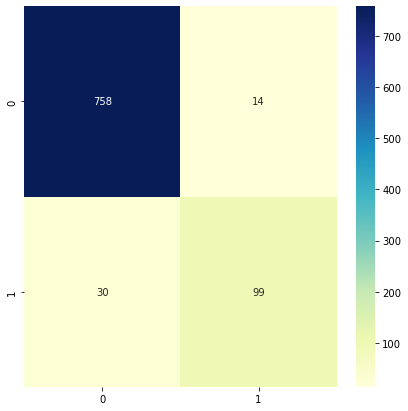

In [ ]:
# trainer.fit(model, train_loader, val_loader)
trainer.fit(model, train_loader, test_loader)

## Test

In [ ]:
# trainer.test(test_dataloaders=val_loader)#, ckpt_path='latest.ckpt')

## Stop online logger

In [ ]:
exp_logger.experiment.stop()

# Mình không cài logger trong lightning module nhưng pl họ tự gọi log khi trainer có logger
# do đó cần xóa logger đi để tránh lỗi khi đã ngưng logger
trainer.logger=None

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 34 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaining 34 operations (0.00% done). Please wait.
Still waiting for the remaini

All 34 operations synced, thanks for waiting!


# Evaluating model

## Visualize misclassified samples

In [ ]:
raise NotImplementedError()

# Inference

## Public test set

In [ ]:
private_set = AICOVIDDataset('f_pub_test', torch.nn.ModuleList([transform0]), normalize=scaler, cleanup_after=False)

> Archive have already downloaded

> Extract complete



100%|██████████████████████████████████████| 1233/1233 [00:07<00:00, 160.84it/s]



> File processing complete

> Start normalizing data



100%|█████████████████████████████████████| 1233/1233 [00:00<00:00, 1397.89it/s]


> Normalizing data complete


In [ ]:
private_loader = torch.utils.data.DataLoader(
    private_set,
    collate_fn=collate_pad_1024_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
preds = trainer.predict(dataloaders=private_loader)
preds = torch.cat(preds)
preds = preds.cpu().numpy()
preds

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 2036it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Predicting: 2036it [00:46, ?it/s]


array([5.010e-01, 6.985e-03, 2.189e-01, ..., 2.187e-02, 5.571e-01,
       3.678e-05], dtype=float16)

# Lưu kết quả

In [ ]:
#@markdown Lưu lại model lên Google Drive
if train_mode:
  os.system('mkdir trained_models')
  compressed_name = f'{zip_name}_model.zip'
  torch.save(model.state_dict(), './trained_models/model_weights.pth')
  
  os.system(f'zip -j ./{compressed_name} ./trained_models/*')
  drive.Upload(compressed_name, model_zoo)

In [ ]:
#@markdown Lưu lại public test submission lên Google Drive
submit_df = pd.DataFrame({'uuid': private_set.meta_df['uuid'],
                          'assessment_result': preds})
submit_df.to_csv('results.csv', index=False)

# Nén file
os.system(f'zip -j ./{zip_name}.zip ./results.csv')

drive.Upload(zip_name+'.zip', submission_folder)

  adding: results.csv (deflated 45%)
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=324036170913-094orce5eji9sr78pstqsi3e6opo5jnp.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code

Opening in existing browser session.
Authentication successful.


In [ ]:
#@markdown Lưu lại private test submission lên Google Drive
submit_df = pd.DataFrame({'uuid': private_test_meta['uuid'],
                          'assessment_result': preds})
submit_df.to_csv('results.csv', index=False)

# Nén file
os.system(f'zip -j ./{zip_name}_private_test.zip ./results.csv')

drive.Upload(zip_name+'_private_test.zip', submission_folder)

In [ ]:
#@markdown Load model lưu sẵn
if not train_mode:
  drive.Download(f'{zip_name}_model.zip', model_zoo)
  os.system(f'unzip -o {zip_name}_model.zip')
  model.load_state_dict(torch.load('model_weights.pth'))